In [1]:
# Import the packages
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers


In [2]:
# Get the original Datasets
df_train = pd.read_csv('imdb_train_clean.csv') #, names = ["sentiment", "review"])

# Drop NaN 
df_train = df_train.dropna()

##checking for nulls
print(df_train.isnull().any())

print("Train subset:", len(df_train)) 

# Use scikit-learn's train_test_split instead
x_train, x_val, y_train, y_val = train_test_split(df_train["review"], df_train["sentiment"], test_size=0.2, random_state=42)

# Check the lengths
len(x_train), len(x_val), len(y_train), len(y_val)

sentiment    False
review       False
dtype: bool
Train subset: 50000


(40000, 10000, 40000, 10000)

In [3]:
# Text vectorization (Tokenization)
# Find average number of tokens (or words) in training dataset
avg_tokens = round(sum([len(i.split()) for i in x_train])/len(x_train))
print("Average number of tokens:", avg_tokens)

# Setup text vectorization with custom variables
max_vocab_len = 100000 # max number of words in vocabulary
max_seq_len = 128

review_vectorizer = TextVectorization(max_tokens=max_vocab_len,
                                      output_mode="int",
                                      output_sequence_length=max_seq_len)

# Fit the text vectorizer to the training text
review_vectorizer.adapt(x_train)

# Get the unique words in the vocabulary
words_in_vocab = review_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens ([UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")


Average number of tokens: 115
Number of words in vocab: 33253
Top 5 most common words: ['', '[UNK]', 'movie', 'film', 'one']
Bottom 5 least common words: ['belden', 'beban', 'backlund', 'alanis', 'agrippina']


In [4]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    
    # Calculate model precision, recall and f1 score using "weighted" average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"Accuracy": model_accuracy,
                     "Precision": model_precision,
                     "Recall": model_recall,
                     "f1": model_f1}
    return model_results

def calculate_model_metrics(true_labels, predictions):
    myAccuracy = aacuracy_score(true_labels[:len(predictions)], predictions) * 100
    myPrecision = precision_score(true_labels[:len(predictions)], predictions)
    myRecall = recall_score(true_labels[:len(predictions)], predictions)
    myF1 = f1_score(true_labels[:len(predictions)], predictions)

    
    myResults = {"Accuracy": myAccuracy,
                     "Precision": myPrecision,
                     "Recall": myRecall,
                     "f1": myF1}
    return myResults

### Baseline Model

In [5]:
# Model 0: Getting a baseline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization 
baseline_model = Pipeline([("tfidf", TfidfVectorizer()),
                    ("clf", MultinomialNB()) 
])

# Fit the model to the training data
baseline_model.fit(x_train, y_train)

# Evaluate the model and find the baseline metric.
baseline_score = baseline_model.score(x_val, y_val)
print(f"Baseline model accuracy: {baseline_score*100:.2f}%")

# Some predictions with our baseline model
baseline_preds = baseline_model.predict(x_val)
baseline_preds[:20]

Baseline model accuracy: 86.74%


array([1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
      dtype=int64)

In [6]:
baseline_results = calculate_results(y_true=y_val,
                                     y_pred=baseline_preds)
baseline_results

{'Accuracy': 86.74,
 'Precision': 0.8675210806875356,
 'Recall': 0.8674,
 'f1': 0.8673993316957594}

### Word Embeddings

In [7]:
# Create GloVe word embeddings
embeddings_index = {}
embedding_dim = 300  # GloVe embeddings dimension (e.g. glove.42B.300d.txt)
glove_file = 'glove.42B.300d.txt'  # Path to the GloVe file
  
with open(glove_file, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
        
# Create an embedding matrix
embedding_matrix = np.zeros((max_vocab_len, embedding_dim))  # Initialize the embedding matrix

# Prepare word_index for GLOVE embeddings 
tokenizer = Tokenizer(num_words=max_vocab_len)
x_train = x_train.astype(str).tolist()
x_val = x_val.astype(str).tolist()

tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(x_train)
val_sequences = tokenizer.texts_to_sequences(x_val)

max_length = 128  # maximum length of sequences
x_train = pad_sequences(train_sequences, maxlen=max_length)
x_val = pad_sequences(val_sequences, maxlen=max_length)

#  Iterate over vocabulary & fetch the respective GloVe embedding vector for each word
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        

### Feed-forward neural network (dense model)

In [8]:
learning_rate = 0.0001
batch_size = 64

# Build model with the Functional API
inputs = layers.Input(shape=(max_length,), dtype="int32") # inputs are 1-dimensional strings

embedding_layer = layers.Embedding(
    max_vocab_len,
    embedding_dim,
    weights=[embedding_matrix],
    trainable=False)(inputs)

x = layers.GlobalAveragePooling1D()(embedding_layer) # lower the dimensionality of the embedding 
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, for binary outputs, use sigmoid activation
dense_model = tf.keras.Model(inputs, outputs, name="Dense_Model") # construct the model

# Compile model
dense_model.compile(
    loss="binary_crossentropy", 
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
    metrics=["accuracy"]
)

dense_model.summary()

Model: "Dense_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding (Embedding)       (None, 128, 300)          30000000  
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 64)                19264     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                       

Epoch 1/50
625/625 [==============================] - 5s 7ms/step - loss: 0.6219 - accuracy: 0.7435 - val_loss: 0.5202 - val_accuracy: 0.7887
Epoch 2/50
625/625 [==============================] - 4s 5ms/step - loss: 0.4615 - accuracy: 0.8105 - val_loss: 0.4256 - val_accuracy: 0.8161
Epoch 3/50
625/625 [==============================] - 4s 5ms/step - loss: 0.4059 - accuracy: 0.8293 - val_loss: 0.3942 - val_accuracy: 0.8277
Epoch 4/50
625/625 [==============================] - 4s 5ms/step - loss: 0.3848 - accuracy: 0.8374 - val_loss: 0.3809 - val_accuracy: 0.8324
Epoch 5/50
625/625 [==============================] - 4s 5ms/step - loss: 0.3742 - accuracy: 0.8407 - val_loss: 0.3728 - val_accuracy: 0.8330
Epoch 6/50
625/625 [==============================] - 4s 5ms/step - loss: 0.3676 - accuracy: 0.8443 - val_loss: 0.3678 - val_accuracy: 0.8371
Epoch 7/50
625/625 [==============================] - 4s 5ms/step - loss: 0.3635 - accuracy: 0.8458 - val_loss: 0.3648 - val_accuracy: 0.8395
Epoch 

<Axes: title={'center': 'dense_model_history IMDB'}>

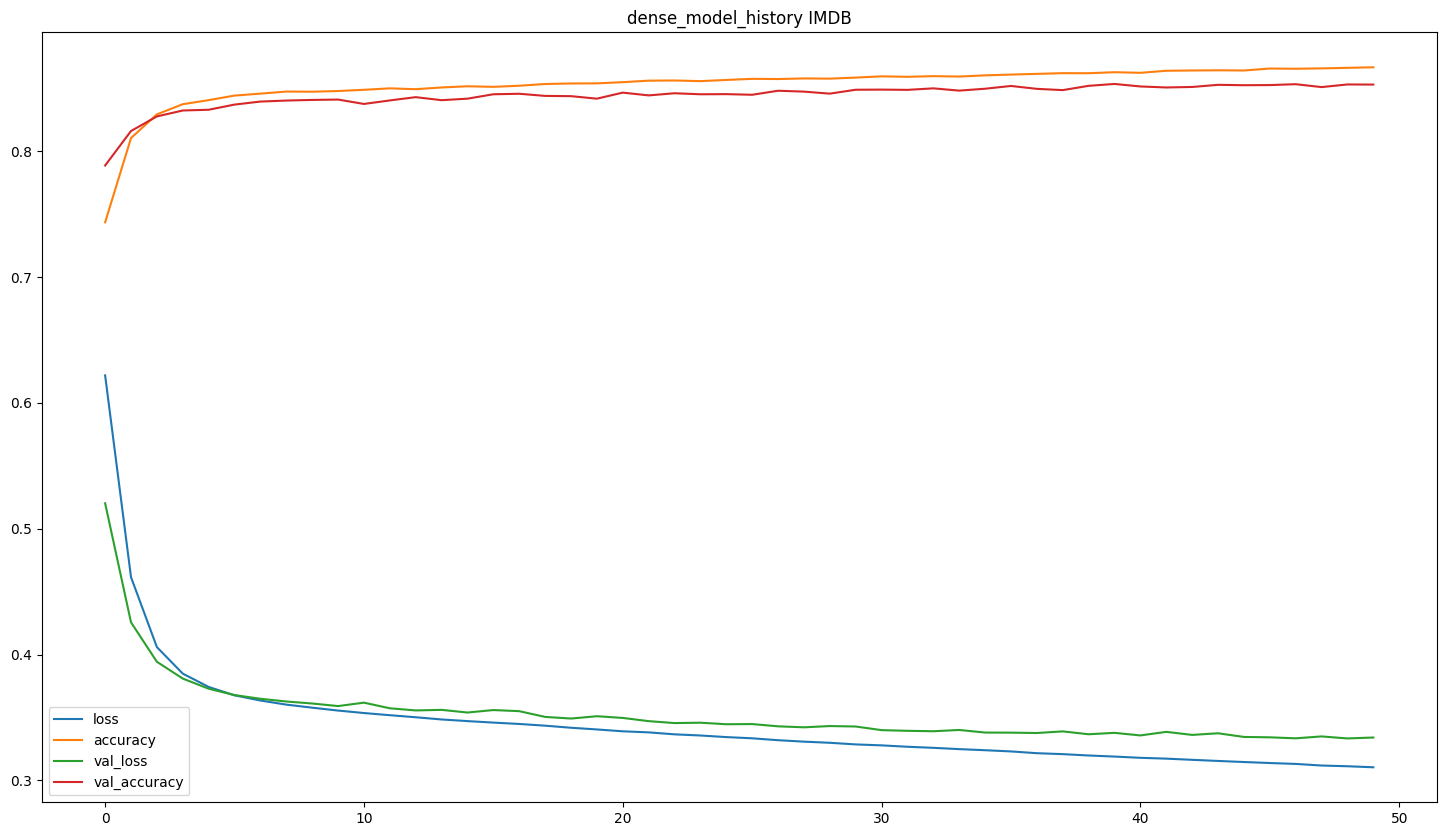

In [9]:
# Fit the model
dense_model_history = dense_model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=batch_size, epochs=50)

# Plot history (loss curve and training curve)
pd.DataFrame(dense_model_history.history).plot(figsize=(18,10), title = "dense_model_history IMDB")

In [10]:
# Check the results
dense_model.evaluate(x_val, y_val)

313/313 [==============================] - 1s 2ms/step - loss: 0.3340 - accuracy: 0.8530


[0.33404478430747986, 0.8529999852180481]

In [11]:
# Make predictions
dense_model_pred_probs = dense_model.predict(x_val)

# prediction probabilities to tensor of floats
dense_model_preds = tf.squeeze(tf.round(dense_model_pred_probs))

# Calculate dense_model metrics
dense_model_results = calculate_results(y_true=y_val, 
                                    y_pred=dense_model_preds)
dense_model_results

313/313 [==============================] - 1s 1ms/step


{'Accuracy': 85.3,
 'Precision': 0.853308319353737,
 'Recall': 0.853,
 'f1': 0.8529463097213511}

### LSTM Model

In [12]:
# Set random seed and create embedding layer
tf.random.set_seed(42)

# Create LSTM model
learning_rate = 0.0001
batch_size = 64

# Build model with the Functional API
inputs = layers.Input(shape=(max_length,), dtype="int32")

embedding_layer = layers.Embedding(
    max_vocab_len,
    embedding_dim,
    weights=[embedding_matrix],
    trainable=False)(inputs)

x = layers.LSTM(64)(embedding_layer)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

lstm_model = models.Model(inputs=inputs, outputs=outputs, name="LSTM_Model")

# Compile the model
lstm_model.compile(
    loss="binary_crossentropy", 
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
    metrics=["accuracy"]
)

# Get a summary of the model
lstm_model.summary()

Model: "LSTM_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 128, 300)          30000000  
                                                                 
 lstm (LSTM)                 (None, 64)                93440     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30,099,713
Trainable params: 99,713
Non-tr

Epoch 1/50
625/625 [==============================] - 23s 23ms/step - loss: 0.4802 - accuracy: 0.7665 - val_loss: 0.3730 - val_accuracy: 0.8355
Epoch 2/50
625/625 [==============================] - 16s 23ms/step - loss: 0.3553 - accuracy: 0.8462 - val_loss: 0.3636 - val_accuracy: 0.8385
Epoch 3/50
625/625 [==============================] - 16s 23ms/step - loss: 0.3304 - accuracy: 0.8556 - val_loss: 0.3391 - val_accuracy: 0.8490
Epoch 4/50
625/625 [==============================] - 12s 23ms/step - loss: 0.3174 - accuracy: 0.8642 - val_loss: 0.3280 - val_accuracy: 0.8574
Epoch 5/50
625/625 [==============================] - 12s 23ms/step - loss: 0.3065 - accuracy: 0.8698 - val_loss: 0.3177 - val_accuracy: 0.8600
Epoch 6/50
625/625 [==============================] - 12s 23ms/step - loss: 0.2988 - accuracy: 0.8730 - val_loss: 0.3131 - val_accuracy: 0.8640
Epoch 7/50
625/625 [==============================] - 12s 23ms/step - loss: 0.2898 - accuracy: 0.8794 - val_loss: 0.3057 - val_accuracy:

<Axes: title={'center': 'lstm_model_history IMDB'}>

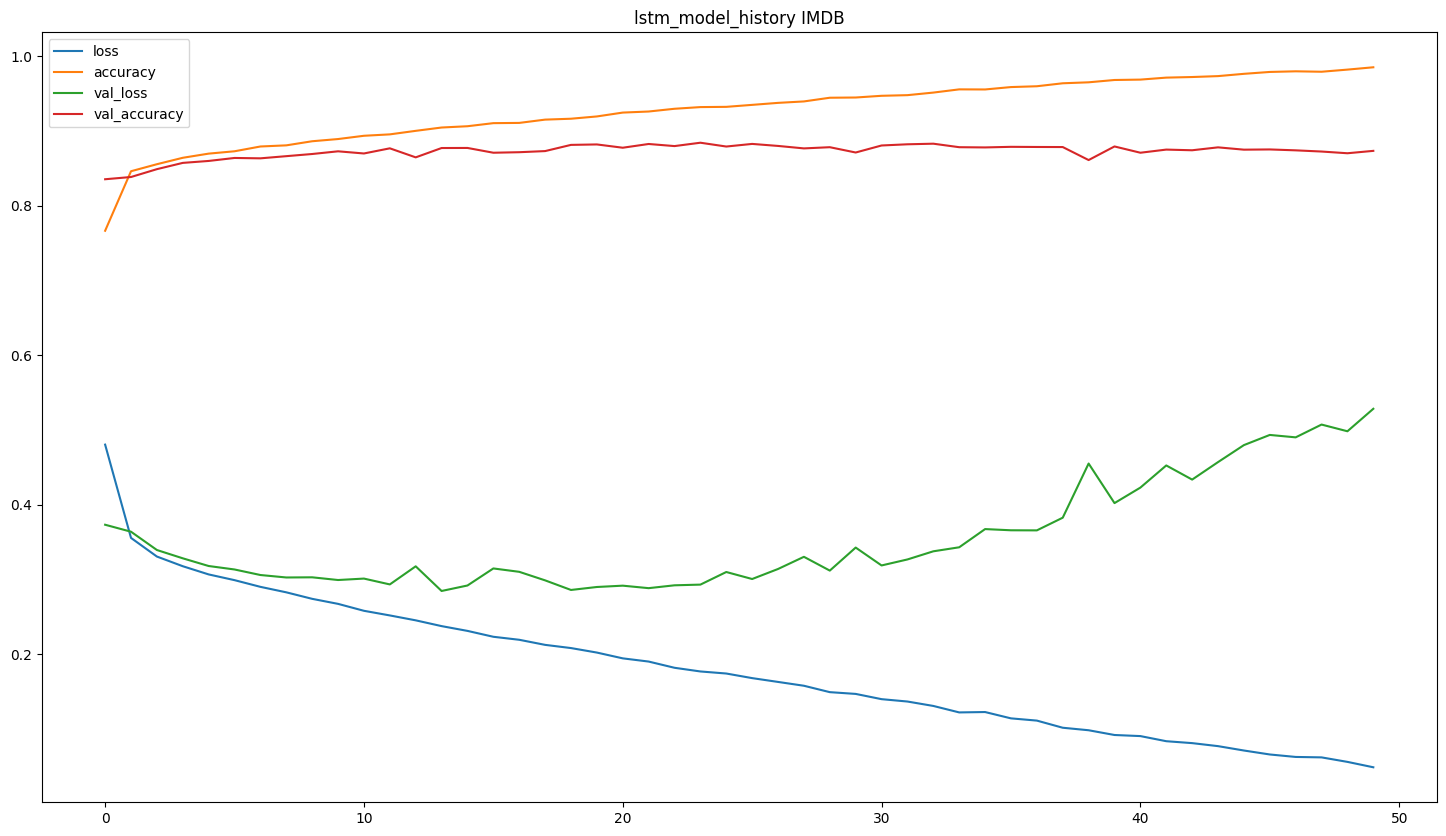

In [13]:
# Fit the LSTM model
lstm_model_history = lstm_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=batch_size)

# Plot history (aka loss curve or a training curve)
pd.DataFrame(lstm_model_history.history).plot(figsize=(18,10), title = "lstm_model_history IMDB")

In [14]:
# Make predictions on the validation dataset
lstm_model_pred_probs = lstm_model.predict(x_val)
# model_2_pred_probs.shape, model_2_pred_probs[:10] # view the first 10

# Round out predictions and reduce to 1-dimensional array
lstm_model_preds = tf.squeeze(tf.round(lstm_model_pred_probs))

# Calculate LSTM model results
lstm_model_results = calculate_results(y_true=y_val,
                                    y_pred=lstm_model_preds)
lstm_model_results

313/313 [==============================] - 1s 2ms/step


{'Accuracy': 87.35000000000001,
 'Precision': 0.8745005651290787,
 'Recall': 0.8735,
 'f1': 0.8733848823902833}

### LSTM Model Version 2

In [15]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)

# Create LSTM model
learning_rate = 0.0001
batch_size = 64

# Build model with the Functional API
inputs = layers.Input(shape=(max_length,), dtype="int32") # inputs are 1-dimensional strings

embedding_layer = layers.Embedding(
    max_vocab_len,
    embedding_dim,
    weights=[embedding_matrix],
    trainable=False)(inputs)

x = layers.LSTM(64)(embedding_layer)
# Add dropout layer
x = layers.Dropout(0.8)(x)  
x = layers.Dense(64, activation="relu")(x)
# Add dropout layer
x = layers.Dropout(0.8)(x)  
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

lstm_model_2 = models.Model(inputs=inputs, outputs=outputs, name="LSTM_Model_V2")


# Compile the model
lstm_model_2.compile(
    loss="binary_crossentropy", 
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
    metrics=["accuracy"]
)

# Get a summary of the model
lstm_model_2.summary()

Model: "LSTM_Model_V2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 128, 300)          30000000  
                                                                 
 lstm_1 (LSTM)               (None, 64)                93440     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 32)              

Epoch 1/50
625/625 [==============================] - 19s 27ms/step - loss: 0.7116 - accuracy: 0.5059 - val_loss: 0.6882 - val_accuracy: 0.5083
Epoch 2/50
625/625 [==============================] - 15s 23ms/step - loss: 0.6842 - accuracy: 0.5479 - val_loss: 0.6348 - val_accuracy: 0.7473
Epoch 3/50
625/625 [==============================] - 15s 23ms/step - loss: 0.5417 - accuracy: 0.7475 - val_loss: 0.4589 - val_accuracy: 0.8247
Epoch 4/50
625/625 [==============================] - 15s 23ms/step - loss: 0.4483 - accuracy: 0.8142 - val_loss: 0.3930 - val_accuracy: 0.8415
Epoch 5/50
625/625 [==============================] - 15s 23ms/step - loss: 0.4195 - accuracy: 0.8318 - val_loss: 0.3881 - val_accuracy: 0.8458
Epoch 6/50
625/625 [==============================] - 15s 23ms/step - loss: 0.3990 - accuracy: 0.8397 - val_loss: 0.3604 - val_accuracy: 0.8500
Epoch 7/50
625/625 [==============================] - 15s 23ms/step - loss: 0.3840 - accuracy: 0.8434 - val_loss: 0.3587 - val_accuracy:

<Axes: title={'center': 'lstm_model_2_history IMDB'}>

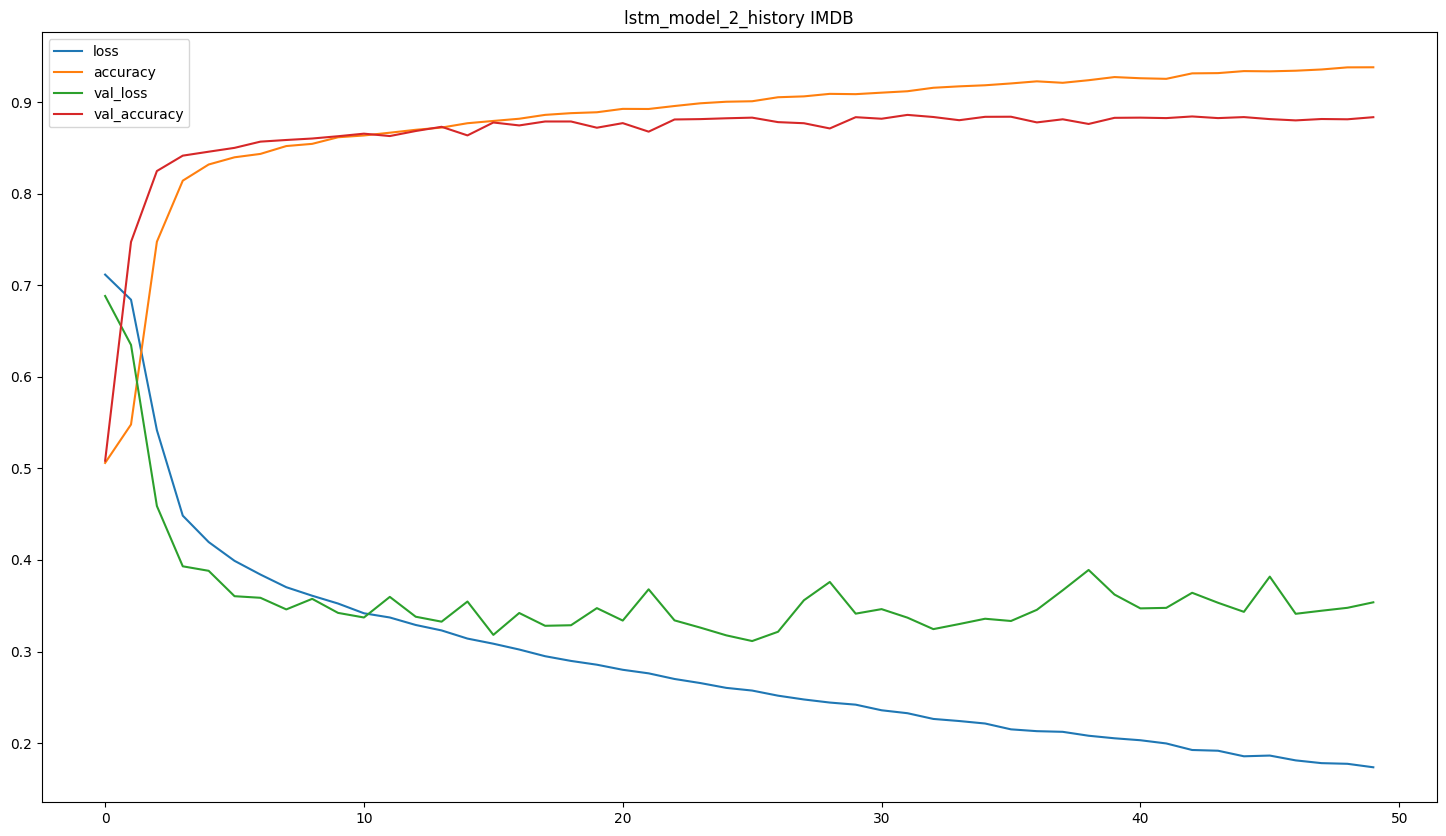

In [16]:
# Fit the LSTM model
lstm_model_2_history = lstm_model_2.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=batch_size)

# Plot history (aka loss curve or a training curve)
pd.DataFrame(lstm_model_2_history.history).plot(figsize=(18,10), title = "lstm_model_2_history IMDB")

In [17]:
# Make predictions on the validation dataset
lstm_model_2_pred_probs = lstm_model_2.predict(x_val)
# model_2_pred_probs.shape, model_2_pred_probs[:10] # view the first 10

# Round out predictions and reduce to 1-dimensional array
lstm_model_2_preds = tf.squeeze(tf.round(lstm_model_2_pred_probs))

# Calculate LSTM model results
lstm_model_2_results = calculate_results(y_true=y_val,
                                    y_pred=lstm_model_2_preds)
lstm_model_2_results

313/313 [==============================] - 1s 2ms/step


{'Accuracy': 88.35,
 'Precision': 0.8836625873325172,
 'Recall': 0.8835,
 'f1': 0.8834762454982883}

### GRU (Gated Recurrent Unit) Model

In [18]:
learning_rate = 0.0001
batch_size = 64

# Build model with the Functional API
inputs = layers.Input(shape=(max_length,), dtype="int32")  # inputs are 1-dimensional strings
embedding_layer = layers.Embedding(
    max_vocab_len,
    embedding_dim,
    weights=[embedding_matrix],
    trainable=False
)(inputs)

x = layers.GRU(64)(embedding_layer)
x = layers.Dropout(0.8)(x)  # Add dropout layer
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.8)(x)  # Add dropout layer
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

gru_model = models.Model(inputs=inputs, outputs=outputs, name="GRU_Model")

# Compile model
gru_model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=["accuracy"]
)

# Get a summary of the model
gru_model.summary()

Model: "GRU_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 128, 300)          30000000  
                                                                 
 gru (GRU)                   (None, 64)                70272     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                20

Epoch 1/50
937/937 [==============================] - 29s 36ms/step - loss: 0.7424 - accuracy: 0.5074 - val_loss: 0.6890 - val_accuracy: 0.5128
Epoch 2/50
937/937 [==============================] - 23s 36ms/step - loss: 0.7070 - accuracy: 0.5153 - val_loss: 0.6869 - val_accuracy: 0.5251
Epoch 3/50
937/937 [==============================] - 16s 29ms/step - loss: 0.6924 - accuracy: 0.5368 - val_loss: 0.6770 - val_accuracy: 0.5981
Epoch 4/50
937/937 [==============================] - 16s 27ms/step - loss: 0.6557 - accuracy: 0.5977 - val_loss: 0.5183 - val_accuracy: 0.7854
Epoch 5/50
937/937 [==============================] - 16s 27ms/step - loss: 0.5095 - accuracy: 0.7707 - val_loss: 0.4197 - val_accuracy: 0.8278
Epoch 6/50
937/937 [==============================] - 16s 27ms/step - loss: 0.4539 - accuracy: 0.8074 - val_loss: 0.3967 - val_accuracy: 0.8396
Epoch 7/50
937/937 [==============================] - 16s 27ms/step - loss: 0.4187 - accuracy: 0.8304 - val_loss: 0.3907 - val_accuracy:

<Axes: title={'center': 'GRU_model_history IMDB'}>

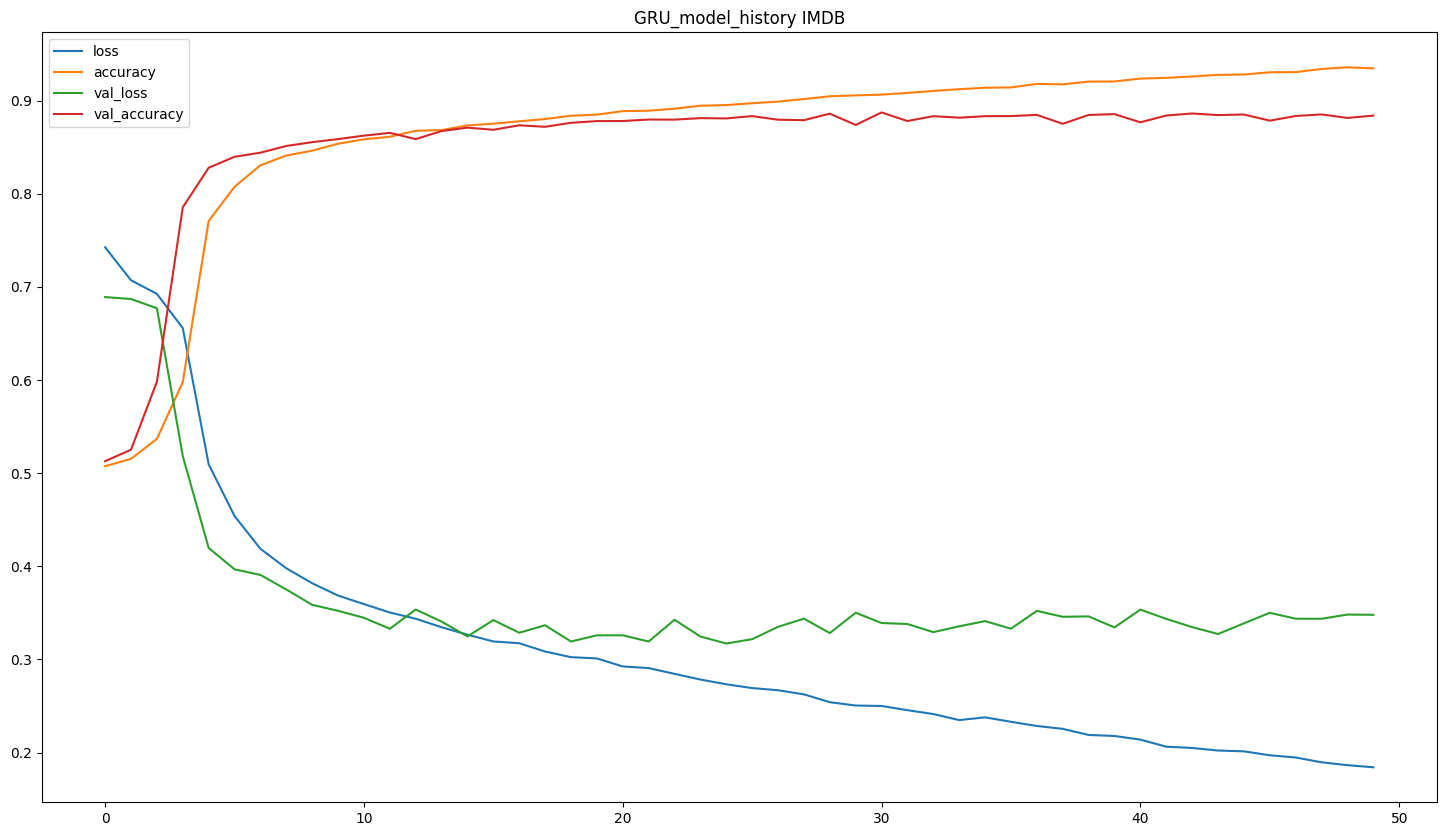

In [19]:
gru_model_history = gru_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=batch_size
)

# Plot history (aka loss curve or a training curve)
pd.DataFrame(gru_model_history.history).plot(figsize=(18,10), title = "GRU_model_history IMDB")

In [20]:
# Make predictions on the validation dataset
gru_model_pred_probs = gru_model.predict(x_val)

# Round out predictions and reduce to 1-dimensional array
gru_model_preds = tf.squeeze(tf.round(gru_model_pred_probs))

# Calculate GRU model results
gru_model_results = calculate_results(y_true=y_val,
                                    y_pred=gru_model_preds)
gru_model_results

313/313 [==============================] - 1s 2ms/step


{'Accuracy': 88.4,
 'Precision': 0.8840043834878226,
 'Recall': 0.884,
 'f1': 0.8840009187600212}

### Bi-LSTM Model

In [21]:
# Define the hyperparameters
learning_rate = 0.00001
batch_size = 64

# Build model with the Functional API
inputs = layers.Input(shape=(max_length,), dtype="int32")  # inputs are 1-dimensional strings
embedding_layer = layers.Embedding(
    max_vocab_len,
    embedding_dim,
    weights=[embedding_matrix],
    trainable=False)(inputs)

# Create a Bidirectional LSTM layer
lstm_layer = layers.Bidirectional(layers.LSTM(64))(embedding_layer)
# Add dropout layer
x = layers.Dropout(0.8)(lstm_layer)  
x = layers.Dense(64, activation="relu")(lstm_layer)
# Add dropout layer
x = layers.Dropout(0.8)(x) 
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

bi_lstm_model = models.Model(inputs=inputs, outputs=outputs, name="BI_LSTM_Model")

# Compile the model
bi_lstm_model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=["accuracy"]
)

# Get a summary of the model
bi_lstm_model.summary()

Model: "BI_LSTM_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 128, 300)          30000000  
                                                                 
 bidirectional (Bidirectiona  (None, 128)              186880    
 l)                                                              
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                     

Epoch 1/50
625/625 [==============================] - 42s 51ms/step - loss: 0.7006 - accuracy: 0.5056 - val_loss: 0.6880 - val_accuracy: 0.5559
Epoch 2/50
625/625 [==============================] - 27s 46ms/step - loss: 0.6908 - accuracy: 0.5285 - val_loss: 0.6822 - val_accuracy: 0.6061
Epoch 3/50
625/625 [==============================] - 27s 46ms/step - loss: 0.6812 - accuracy: 0.5623 - val_loss: 0.6702 - val_accuracy: 0.6568
Epoch 4/50
625/625 [==============================] - 27s 46ms/step - loss: 0.6623 - accuracy: 0.6170 - val_loss: 0.6359 - val_accuracy: 0.7307
Epoch 5/50
625/625 [==============================] - 27s 46ms/step - loss: 0.5945 - accuracy: 0.7194 - val_loss: 0.5357 - val_accuracy: 0.7843
Epoch 6/50
625/625 [==============================] - 27s 46ms/step - loss: 0.5300 - accuracy: 0.7825 - val_loss: 0.4967 - val_accuracy: 0.7973
Epoch 7/50
625/625 [==============================] - 27s 46ms/step - loss: 0.5039 - accuracy: 0.7976 - val_loss: 0.4703 - val_accuracy:

<Axes: title={'center': 'bi_lstm_model_history IMDB'}>

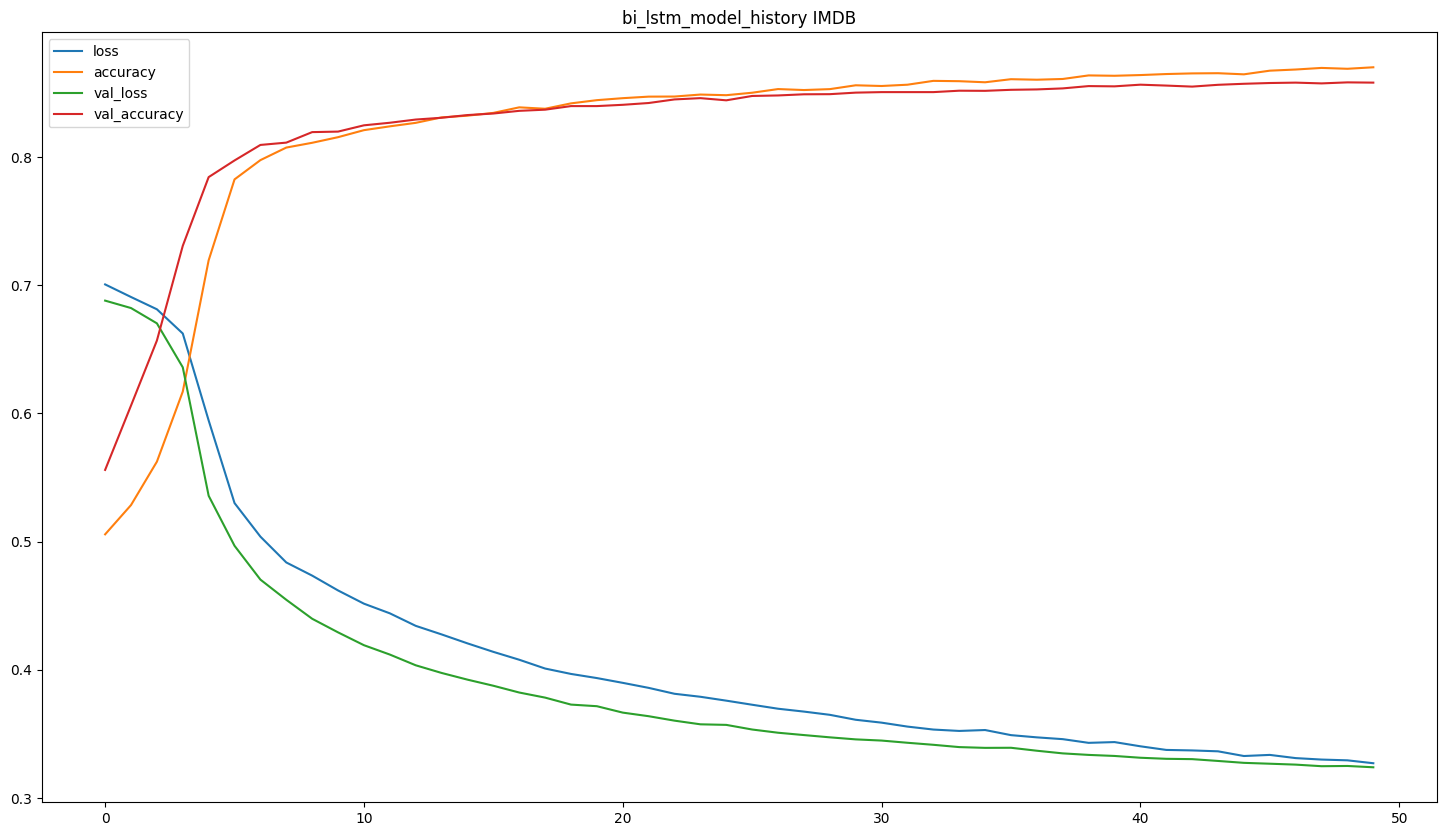

In [22]:
bi_lstm_model_history = bi_lstm_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=batch_size
)

# Plot history (aka loss curve or a training curve)
pd.DataFrame(bi_lstm_model_history.history).plot(figsize=(18,10), title = "bi_lstm_model_history IMDB")

In [23]:
# Make predictions on the validation dataset
bi_lstm_model_pred_probs = bi_lstm_model.predict(x_val)
# model_2_pred_probs.shape, model_2_pred_probs[:10] # view the first 10

# Round out predictions and reduce to 1-dimensional array
bi_lstm_model_preds = tf.squeeze(tf.round(bi_lstm_model_pred_probs))
bi_lstm_model_preds[:10]

# Calculate LSTM model results
bi_lstm_model_results = calculate_results(y_true=y_val,
                                    y_pred=bi_lstm_model_preds)
bi_lstm_model_results

313/313 [==============================] - 1s 3ms/step


{'Accuracy': 85.8,
 'Precision': 0.8581610001941419,
 'Recall': 0.858,
 'f1': 0.8579689075780896}

### BERT Model V1

In [1]:
# Import the packages
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig

# Get the original Datasets
df_train = pd.read_csv('imdb_train_clean.csv') #, names = ["sentiment", "review"])

# Drop NaN 
df_train = df_train.dropna()

##checking for nulls
print(df_train.isnull().any())

print("Train subset:", len(df_train)) 

# Use scikit-learn's train_test_split 
x_train, x_val, y_train, y_val = train_test_split(df_train["review"], df_train["sentiment"], test_size=0.2, random_state=42)

# Check the lengths
print(len(x_train), len(x_val), len(y_train), len(y_val))

# Tokenization with BERT-Tokenizer
max_length = 128 # max length for each sequence
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenization with Truncation und Padding
train_encodings = tokenizer(list(x_train), truncation=True, padding='max_length', max_length=max_length)
val_encodings = tokenizer(list(x_val), truncation=True, padding='max_length', max_length=max_length)

# Check input lengths training
print(len(train_encodings['input_ids'][0]))  
print(len(train_encodings['attention_mask'][0])) 

# Check input lengths validation
print(len(val_encodings['input_ids'][0]))
print(len(val_encodings['attention_mask'][0]))

# Create TensorFlow-Datasets for train 
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))

# Create TensorFlow-Datasets for validation
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val
))

C:\Users\Nasrat\anaconda3\envs\tensorflow\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


sentiment    False
review       False
dtype: bool
Train subset: 50000
40000 10000 40000 10000
128
128
128
128


In [2]:
# Config for BERT-Model
config = BertConfig.from_pretrained('bert-base-uncased', output_attentions=True, output_hidden_states=True, use_cache=False)

# Load the BERT model from_pretrained
bert_model_1 = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)

# Freeze the BERT layers
bert_model_1.bert.trainable = False  

# Compile the model
bert_model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=bert_model_1.hf_compute_loss,
              metrics=['accuracy'])

## Get summary of the model
bert_model_1.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 1,538
Non-trainable params: 109,482,240
_________________________________________________________________


Epoch 1/50
625/625 [==============================] - 628s 1s/step - loss: 0.6156 - accuracy: 0.6615 - val_loss: 0.5510 - val_accuracy: 0.7362
Epoch 2/50
625/625 [==============================] - 614s 997ms/step - loss: 0.5658 - accuracy: 0.7090 - val_loss: 0.5201 - val_accuracy: 0.7530
Epoch 3/50
625/625 [==============================] - 624s 1s/step - loss: 0.5547 - accuracy: 0.7193 - val_loss: 0.5198 - val_accuracy: 0.7415
Epoch 4/50
625/625 [==============================] - 614s 998ms/step - loss: 0.5482 - accuracy: 0.7211 - val_loss: 0.5038 - val_accuracy: 0.7601
Epoch 5/50
625/625 [==============================] - 614s 996ms/step - loss: 0.5448 - accuracy: 0.7237 - val_loss: 0.5032 - val_accuracy: 0.7594
Epoch 6/50
625/625 [==============================] - 604s 966ms/step - loss: 0.5406 - accuracy: 0.7278 - val_loss: 0.4946 - val_accuracy: 0.7634
Epoch 7/50
625/625 [==============================] - 614s 996ms/step - loss: 0.5408 - accuracy: 0.7250 - val_loss: 0.4960 - val_a

<Axes: title={'center': 'bert_model_1_history IMDB'}>

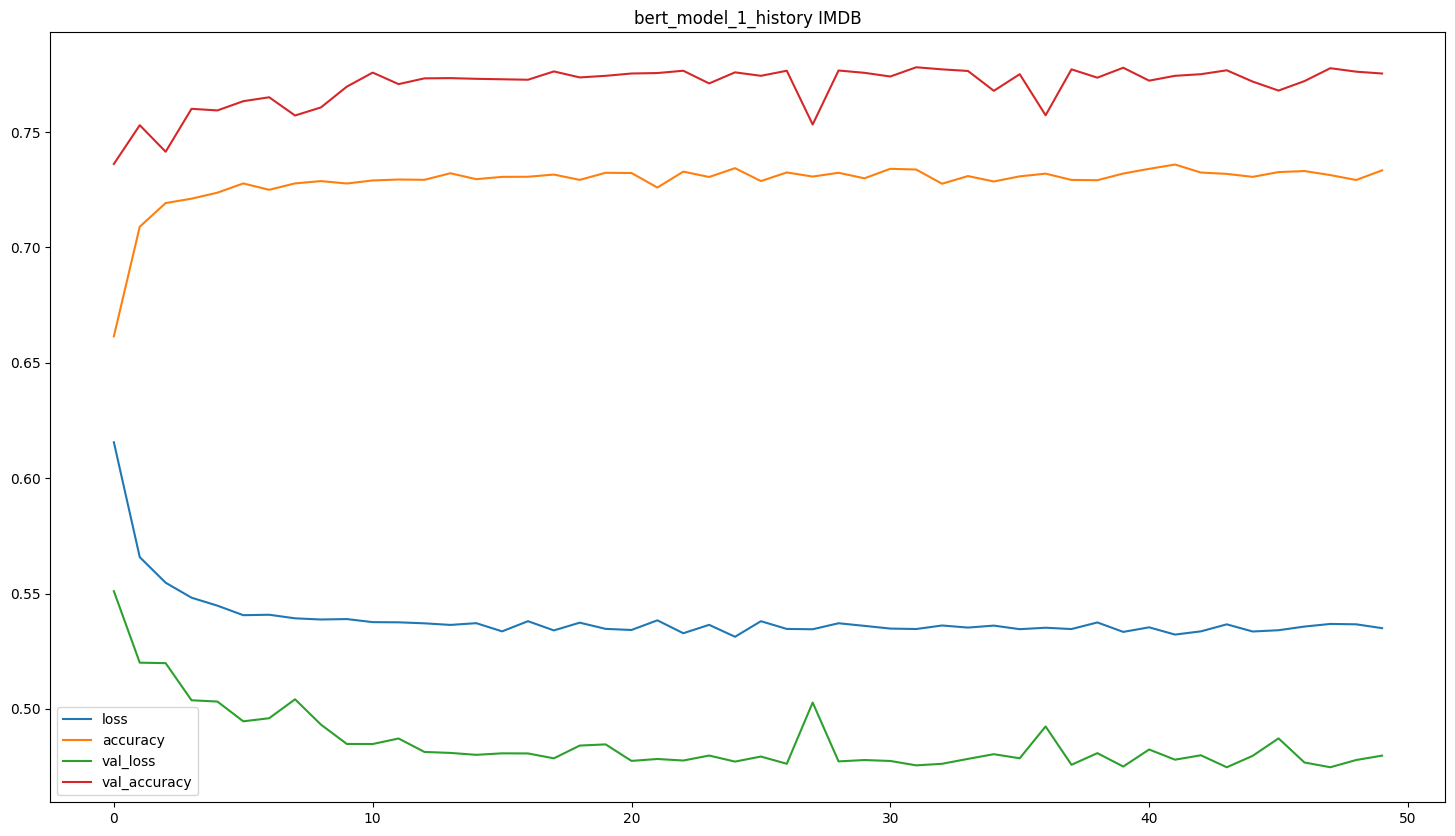

In [3]:
# Train the model 
bert_model_1_history = bert_model_1.fit(train_dataset.shuffle(1000).batch(64),
                                    epochs=50,
                                    validation_data=val_dataset.shuffle(1000).batch(64))

# Plot history (aka loss curve or a training curve)
pd.DataFrame(bert_model_1_history.history).plot(figsize=(18,10), title = "bert_model_1_history IMDB")

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

batch_size = 32
predictions = []

# Iterate through validation data in batches
for i in range(0, len(x_val), batch_size):
    batch_inputs = tokenizer(list(x_val[i: i + batch_size]), padding=True, truncation=True, max_length=128, return_tensors='tf')
    batch_predictions = bert_model_1(batch_inputs)
    
    # Get the predicted class
    batch_predictions = tf.argmax(batch_predictions.logits, axis=1).numpy() 
    predictions.extend(batch_predictions)

# Convert predictions to numpy array
predictions = np.array(predictions)

# Evaluate metrics
accuracy = accuracy_score(y_val[:len(predictions)], predictions)
precision = precision_score(y_val[:len(predictions)], predictions)
recall = recall_score(y_val[:len(predictions)], predictions)
f1 = f1_score(y_val[:len(predictions)], predictions)

print("Validation Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("f1:", f1)

Validation Accuracy: 0.7755
Precision: 0.751349406261245
Recall: 0.82873586028974
f1: 0.788147588940266


### BERT Model V2 (With 1 Unfrozen Layer)

In [1]:
# Import the packages
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig

# Get the original Datasets
df_train = pd.read_csv('imdb_train_clean.csv') #, names = ["sentiment", "review"])


# Drop NaN 
df_train = df_train.dropna()

##checking for nulls
print(df_train.isnull().any())

print("Train subset:", len(df_train)) 

# Use scikit-learn's train_test_split 
x_train, x_val, y_train, y_val = train_test_split(df_train["review"], df_train["sentiment"], test_size=0.2, random_state=42)

# Check the lengths
print(len(x_train), len(x_val), len(y_train), len(y_val))

# Tokenization with BERT-Tokenizer
max_length = 64 # max length for each sequence
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenization with Truncation und Padding
train_encodings = tokenizer(list(x_train), truncation=True, padding='max_length', max_length=max_length)
val_encodings = tokenizer(list(x_val), truncation=True, padding='max_length', max_length=max_length)

# Check input lengths training
print(len(train_encodings['input_ids'][0]))  
print(len(train_encodings['attention_mask'][0])) 

# Check input lengths validation
print(len(val_encodings['input_ids'][0]))
print(len(val_encodings['attention_mask'][0]))

# Create TensorFlow-Datasets for train 
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))

# Create TensorFlow-Datasets for validation
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val
))

C:\Users\Nasrat\anaconda3\envs\tensorflow\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


sentiment    False
review       False
dtype: bool
Train subset: 50000
40000 10000 40000 10000
64
64
64
64


In [2]:
# Config for BERT-Model
config = BertConfig.from_pretrained('bert-base-uncased', output_attentions=True, output_hidden_states=True, use_cache=False)

# Load the BERT model from_pretrained
bert_model_2 = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)

# Number of layers you want to unfreeze
N = 1

# Freeze all layers first
for layer in bert_model_2.bert.encoder.layer:
    layer.trainable = False

# Unfreeze the last N layers
for layer in bert_model_2.bert.encoder.layer[-N:]:
    layer.trainable = True

# Verify by printing the trainable status of each layer
for i, layer in enumerate(bert_model_2.bert.encoder.layer):
    print(f'Layer {i+1} trainable: {layer.trainable}')

# Compile the model
bert_model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=bert_model_2.hf_compute_loss,
              metrics=['accuracy'])

# Get a summary of the model
bert_model_2.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Layer 1 trainable: False
Layer 2 trainable: False
Layer 3 trainable: False
Layer 4 trainable: False
Layer 5 trainable: False
Layer 6 trainable: False
Layer 7 trainable: False
Layer 8 trainable: False
Layer 9 trainable: False
Layer 10 trainable: False
Layer 11 trainable: False
Layer 12 trainable: True
Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 31,517,186
Non-trainable params: 77,966,592
_____________________________________

Epoch 1/50
1250/1250 [==============================] - 1215s 901ms/step - loss: 0.4612 - accuracy: 0.7843 - val_loss: 0.4256 - val_accuracy: 0.8130
Epoch 2/50
1250/1250 [==============================] - 1105s 886ms/step - loss: 0.2978 - accuracy: 0.8762 - val_loss: 0.5202 - val_accuracy: 0.8336
Epoch 3/50
1250/1250 [==============================] - 1105s 886ms/step - loss: 0.2194 - accuracy: 0.9173 - val_loss: 0.5437 - val_accuracy: 0.7915
Epoch 4/50
1250/1250 [==============================] - 1105s 886ms/step - loss: 0.1726 - accuracy: 0.9360 - val_loss: 0.6056 - val_accuracy: 0.8209
Epoch 5/50
1250/1250 [==============================] - 1105s 886ms/step - loss: 0.1155 - accuracy: 0.9595 - val_loss: 0.8109 - val_accuracy: 0.8199
Epoch 6/50
1250/1250 [==============================] - 1105s 886ms/step - loss: 0.1071 - accuracy: 0.9651 - val_loss: 0.7211 - val_accuracy: 0.8231
Epoch 7/50
1250/1250 [==============================] - 1105s 886ms/step - loss: 0.1066 - accuracy: 0.9656

<Axes: title={'center': 'bert_model_2_history IMDB'}>

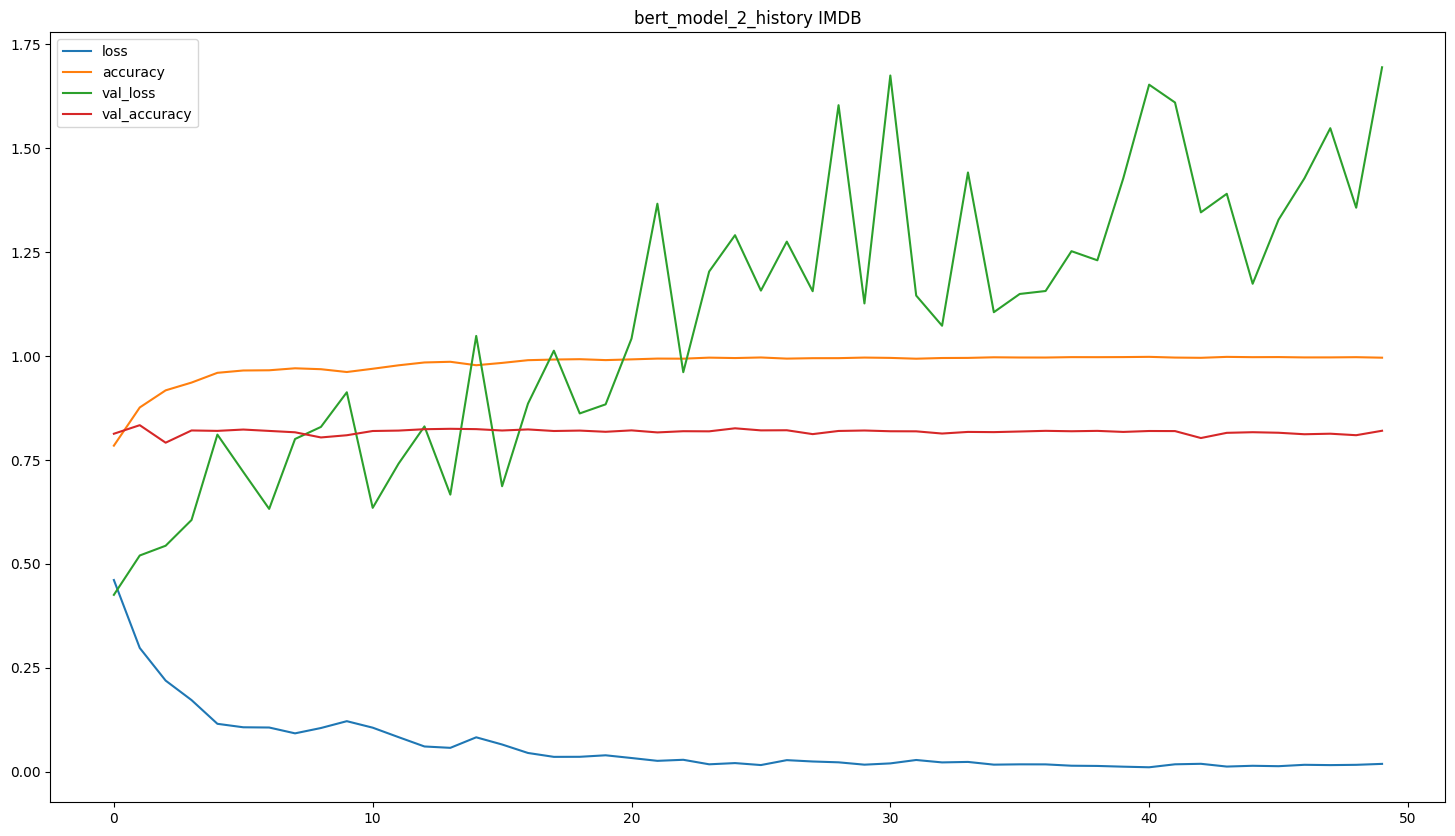

In [3]:
# Train the model 
bert_model_2_history = bert_model_2.fit(train_dataset.shuffle(1000).batch(32),
                                    epochs=50,
                                    batch_size=32,
                                    validation_data=val_dataset.shuffle(1000).batch(32))

# Plot history (aka loss curve or a training curve)
pd.DataFrame(bert_model_2_history.history).plot(figsize=(18,10), title = "bert_model_2_history IMDB")

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

batch_size = 32
predictions = []

# Iterate through validation data in batches
for i in range(0, len(x_val), batch_size):
    batch_inputs = tokenizer(list(x_val[i: i + batch_size]), padding=True, truncation=True, max_length=128, return_tensors='tf')
    batch_predictions = bert_model_2(batch_inputs)
    batch_predictions = tf.argmax(batch_predictions.logits, axis=1).numpy() # Assuming binary classification, get the predicted class
    predictions.extend(batch_predictions)

# Convert predictions to a numpy array
predictions = np.array(predictions)

# Evaluate metrics
accuracy = accuracy_score(y_val[:len(predictions)], predictions)
precision = precision_score(y_val[:len(predictions)], predictions)
recall = recall_score(y_val[:len(predictions)], predictions)
f1 = f1_score(y_val[:len(predictions)], predictions)

print("Validation Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("f1:", f1)

Validation Accuracy: 0.8202103
Precision: 0.800692924872356
Recall: 0.8714030561619369
f1: 0.8345528841585099


### BERT Model V3 (With Dropout)

In [1]:
# Import the packages
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras import layers, models
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig

# Get the original Datasets
df_train = pd.read_csv('imdb_train_clean.csv') #, names = ["sentiment", "review"])

# Drop NaN 
df_train = df_train.dropna()

##checking for nulls
print(df_train.isnull().any())

print("Train subset:", len(df_train)) 

# Use scikit-learn's train_test_split 
x_train, x_val, y_train, y_val = train_test_split(df_train["review"], df_train["sentiment"], test_size=0.2, random_state=42)

# Check the lengths
print(len(x_train), len(x_val), len(y_train), len(y_val))

# Tokenization with BERT-Tokenizer
max_length = 64 # max length for each sequence
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenization with Truncation und Padding
train_encodings = tokenizer(list(x_train), truncation=True, padding='max_length', max_length=max_length)
val_encodings = tokenizer(list(x_val), truncation=True, padding='max_length', max_length=max_length)

# Check input lengths training
print(len(train_encodings['input_ids'][0]))  
print(len(train_encodings['attention_mask'][0])) 

# Check input lengths validation
print(len(val_encodings['input_ids'][0]))
print(len(val_encodings['attention_mask'][0]))

# Create TensorFlow-Datasets for train 
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))

# Create TensorFlow-Datasets for validation
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val
))


C:\Users\Nasrat\anaconda3\envs\tensorflow\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


sentiment    False
review       False
dtype: bool
Train subset: 50000
40000 10000 40000 10000
64
64
64
64


In [2]:
# Config for BERT-Model
config = BertConfig.from_pretrained('bert-base-uncased', output_attentions=True, output_hidden_states=True, use_cache=False)

# Load the BERT model from_pretrained
bert_model_3 = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)

# Freeze all layers first
for layer in bert_model_3.bert.encoder.layer:
    layer.trainable = False

# Unfreeze the last layer
for layer in bert_model_3.bert.encoder.layer[-1:]:
    layer.trainable = True

# Verify by printing the trainable status of each layer
for i, layer in enumerate(bert_model_3.bert.encoder.layer):
    print(f'Layer {i+1} trainable: {layer.trainable}')
    
input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='attention_mask')

outputs = bert_model_3(input_ids, attention_mask=attention_mask)
dropout = Dropout(0.5)(outputs[0]) # Add dropout with 50% rate
output = Dense(1, activation='sigmoid')(dropout)

# Create a new model that includes the dropout
new_bert_model_3 = Model(inputs=[input_ids, attention_mask], outputs=output)

# Compile the model
new_bert_model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=bert_model_3.hf_compute_loss,
              metrics=['accuracy'])

# Get a summary of the model
new_bert_model_3.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Layer 1 trainable: False
Layer 2 trainable: False
Layer 3 trainable: False
Layer 4 trainable: False
Layer 5 trainable: False
Layer 6 trainable: False
Layer 7 trainable: False
Layer 8 trainable: False
Layer 9 trainable: False
Layer 10 trainable: False
Layer 11 trainable: False
Layer 12 trainable: True
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, None)]       0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  109483778  ['input_ids[0][0]',     

Epoch 1/50


C:\Users\Nasrat\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\functional.py:637: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


2500/2500 [==============================] - 1728s 659ms/step - loss: 0.1876 - accuracy: 0.6969 - val_loss: 0.1491 - val_accuracy: 0.7916
Epoch 2/50
2500/2500 [==============================] - 1641s 659ms/step - loss: 0.1582 - accuracy: 0.7426 - val_loss: 0.1293 - val_accuracy: 0.8213
Epoch 3/50
2500/2500 [==============================] - 1635s 653ms/step - loss: 0.1401 - accuracy: 0.7737 - val_loss: 0.1219 - val_accuracy: 0.8311
Epoch 4/50
2500/2500 [==============================] - 1614s 646ms/step - loss: 0.1271 - accuracy: 0.7877 - val_loss: 0.1399 - val_accuracy: 0.8015
Epoch 5/50
2500/2500 [==============================] - 1625s 650ms/step - loss: 0.1205 - accuracy: 0.8019 - val_loss: 0.1391 - val_accuracy: 0.8145
Epoch 6/50
2500/2500 [==============================] - 1625s 650ms/step - loss: 0.1099 - accuracy: 0.8160 - val_loss: 0.1494 - val_accuracy: 0.8101
Epoch 7/50
2500/2500 [==============================] - 1625s 650ms/step - loss: 0.0999 - accuracy: 0.8286 - val_loss

<Axes: title={'center': 'bert_model_3_history IMDB'}>

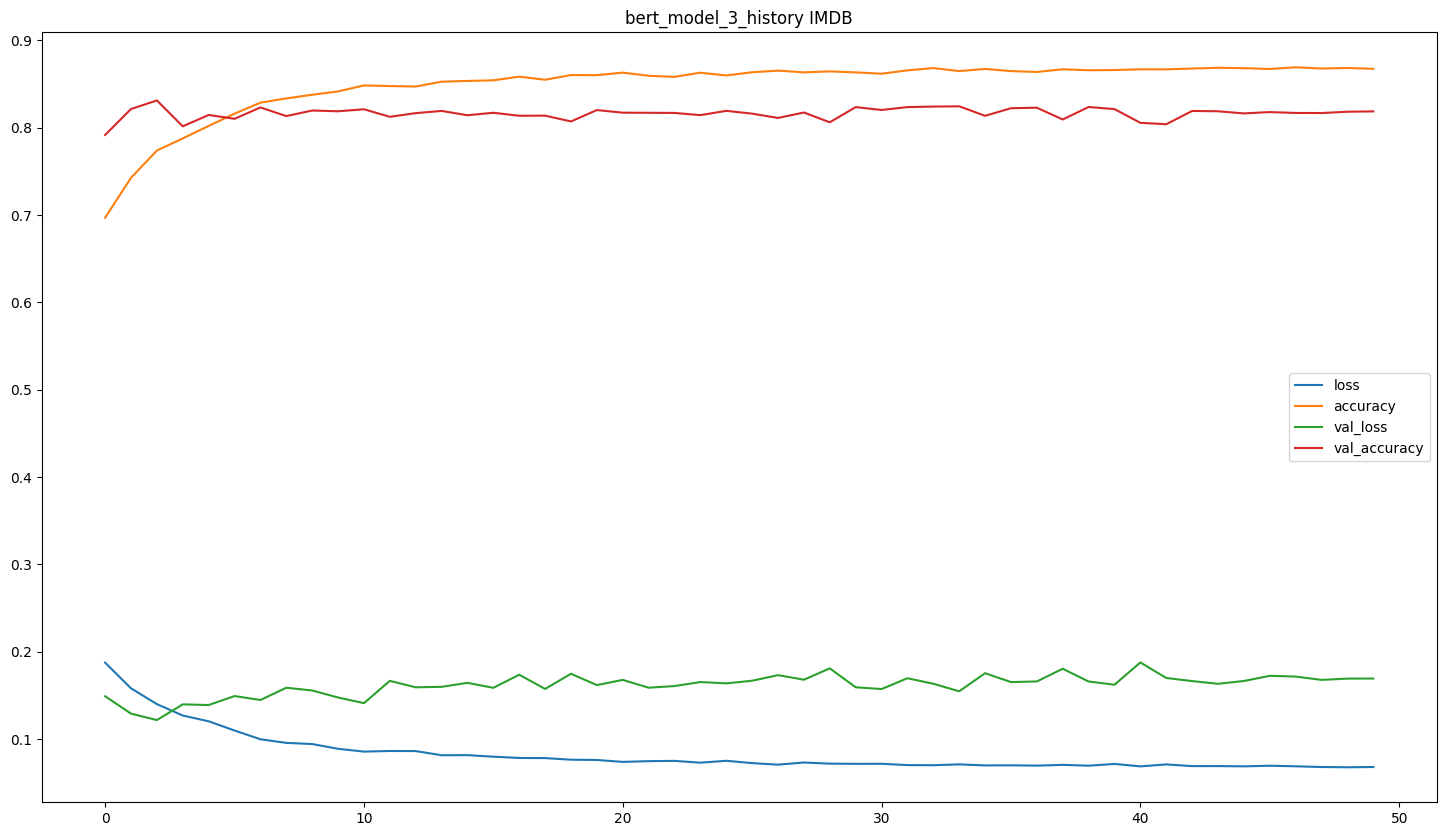

In [3]:
# Train the model 
new_bert_model_3_history = new_bert_model_3.fit(train_dataset.shuffle(1000).batch(16),
                                    epochs=50,
                                    validation_data=val_dataset.shuffle(1000).batch(16))

# Plot history (aka loss curve or a training curve)
pd.DataFrame(new_bert_model_3_history.history).plot(figsize=(18,10), title = "bert_model_3_history IMDB")

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

batch_size = 32
predictions = []

# Iterate through validation data in batches
for i in range(0, len(x_val), batch_size):
    batch_tokenized = tokenizer(list(x_val[i: i + batch_size]), padding='max_length', truncation=True, max_length=max_length, return_tensors='tf')
    
    # Only select the input_ids and attention_mask from the tokenized data
    batch_inputs = {'input_ids': batch_tokenized['input_ids'], 'attention_mask': batch_tokenized['attention_mask']}
   
    # Move to CPU 
    with tf.device('/CPU:0'):
        batch_predictions = new_bert_model_3(batch_inputs)
    
        # Get the predicted class 
        # Threshold these probabilities at 0.5
        batch_predictions = (batch_predictions > 0.5).numpy().astype(int).flatten()

        predictions.extend(batch_predictions)

# Convert predictions to a numpy array
predictions = np.array(predictions)

# Evaluate metrics
accuracy = accuracy_score(y_val[:len(predictions)], predictions)
precision = precision_score(y_val[:len(predictions)], predictions)
recall = recall_score(y_val[:len(predictions)], predictions)
f1 = f1_score(y_val[:len(predictions)], predictions)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("f1:", f1)

Accuracy: 0.8186
Precision: 0.7948436642896325
Recall: 0.8626711649136733
f1: 0.827369623144271


### BERT Model V4 (With Dropout and Early Stopping)

In [2]:
# Import the packages
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras import layers, models
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig

# Get the original Datasets
df_train = pd.read_csv('imdb_train_clean.csv') #, names = ["sentiment", "review"])

# Drop NaN 
df_train = df_train.dropna()

##checking for nulls
print(df_train.isnull().any())

print("Train subset:", len(df_train)) 

# Use scikit-learn's train_test_split 
x_train, x_val, y_train, y_val = train_test_split(df_train["review"], df_train["sentiment"], test_size=0.2, random_state=42)

# Check the lengths
print(len(x_train), len(x_val), len(y_train), len(y_val))

# Tokenization with BERT-Tokenizer
max_length = 64 # max length for each sequence
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenization with Truncation und Padding
train_encodings = tokenizer(list(x_train), truncation=True, padding='max_length', max_length=max_length)
val_encodings = tokenizer(list(x_val), truncation=True, padding='max_length', max_length=max_length)

# Check input lengths training
print(len(train_encodings['input_ids'][0]))  
print(len(train_encodings['attention_mask'][0])) 

# Check input lengths validation
print(len(val_encodings['input_ids'][0]))
print(len(val_encodings['attention_mask'][0]))

# Create TensorFlow-Datasets for train 
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))

# Create TensorFlow-Datasets for validation
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val
))


C:\Users\Nasrat\anaconda3\envs\tensorflow\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


sentiment    False
review       False
dtype: bool
Train subset: 50000
40000 10000 40000 10000
64
64
64
64


In [3]:
# Config for BERT-Model
config = BertConfig.from_pretrained('bert-base-uncased', output_attentions=True, output_hidden_states=True, use_cache=False)

# Load the BERT model from_pretrained
bert_model_4 = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)

# Freeze all layers first
for layer in bert_model_4.bert.encoder.layer:
    layer.trainable = False

# Unfreeze the last layer
for layer in bert_model_4.bert.encoder.layer[-1:]:
    layer.trainable = True

# Verify by printing the trainable status of each layer
for i, layer in enumerate(bert_model_4.bert.encoder.layer):
    print(f'Layer {i+1} trainable: {layer.trainable}')
    
input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='attention_mask')

outputs = bert_model_4(input_ids, attention_mask=attention_mask)
dropout = Dropout(0.5)(outputs[0]) # Add dropout with 50% rate
output = Dense(1, activation='sigmoid')(dropout)

# Create a new model that includes the dropout
new_bert_model_4 = Model(inputs=[input_ids, attention_mask], outputs=output)


# Compile the model
new_bert_model_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=bert_model_4.hf_compute_loss,
              metrics=['accuracy'])

# Get a summary of the model
new_bert_model_4.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Layer 1 trainable: False
Layer 2 trainable: False
Layer 3 trainable: False
Layer 4 trainable: False
Layer 5 trainable: False
Layer 6 trainable: False
Layer 7 trainable: False
Layer 8 trainable: False
Layer 9 trainable: False
Layer 10 trainable: False
Layer 11 trainable: False
Layer 12 trainable: True
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, None)]       0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  109483778  ['input_ids[0][0]',     

Epoch 1/50


C:\Users\Nasrat\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\functional.py:637: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


2500/2500 [==============================] - 1976s 739ms/step - loss: 0.1882 - accuracy: 0.6962 - val_loss: 0.1290 - val_accuracy: 0.8189
Epoch 2/50
2500/2500 [==============================] - 1806s 724ms/step - loss: 0.1510 - accuracy: 0.7549 - val_loss: 0.1403 - val_accuracy: 0.8206
Epoch 3/50
2500/2500 [==============================] - 1804s 723ms/step - loss: 0.2032 - accuracy: 0.6169 - val_loss: 0.2500 - val_accuracy: 0.5039
Epoch 4/50
2500/2500 [==============================] - 1804s 721ms/step - loss: 0.2099 - accuracy: 0.6088 - val_loss: 0.1289 - val_accuracy: 0.8220
Epoch 5/50
2500/2500 [==============================] - 1804s 721ms/step - loss: 0.1377 - accuracy: 0.7766 - val_loss: 0.1245 - val_accuracy: 0.8290
Epoch 6/50
2500/2500 [==============================] - 1794s 718ms/step - loss: 0.1258 - accuracy: 0.7906 - val_loss: 0.1543 - val_accuracy: 0.7999
Epoch 7/50
2500/2500 [==============================] - 1791s 716ms/step - loss: 0.1207 - accuracy: 0.8020 - val_loss

<Axes: title={'center': 'bert_model_4_history IMDB'}>

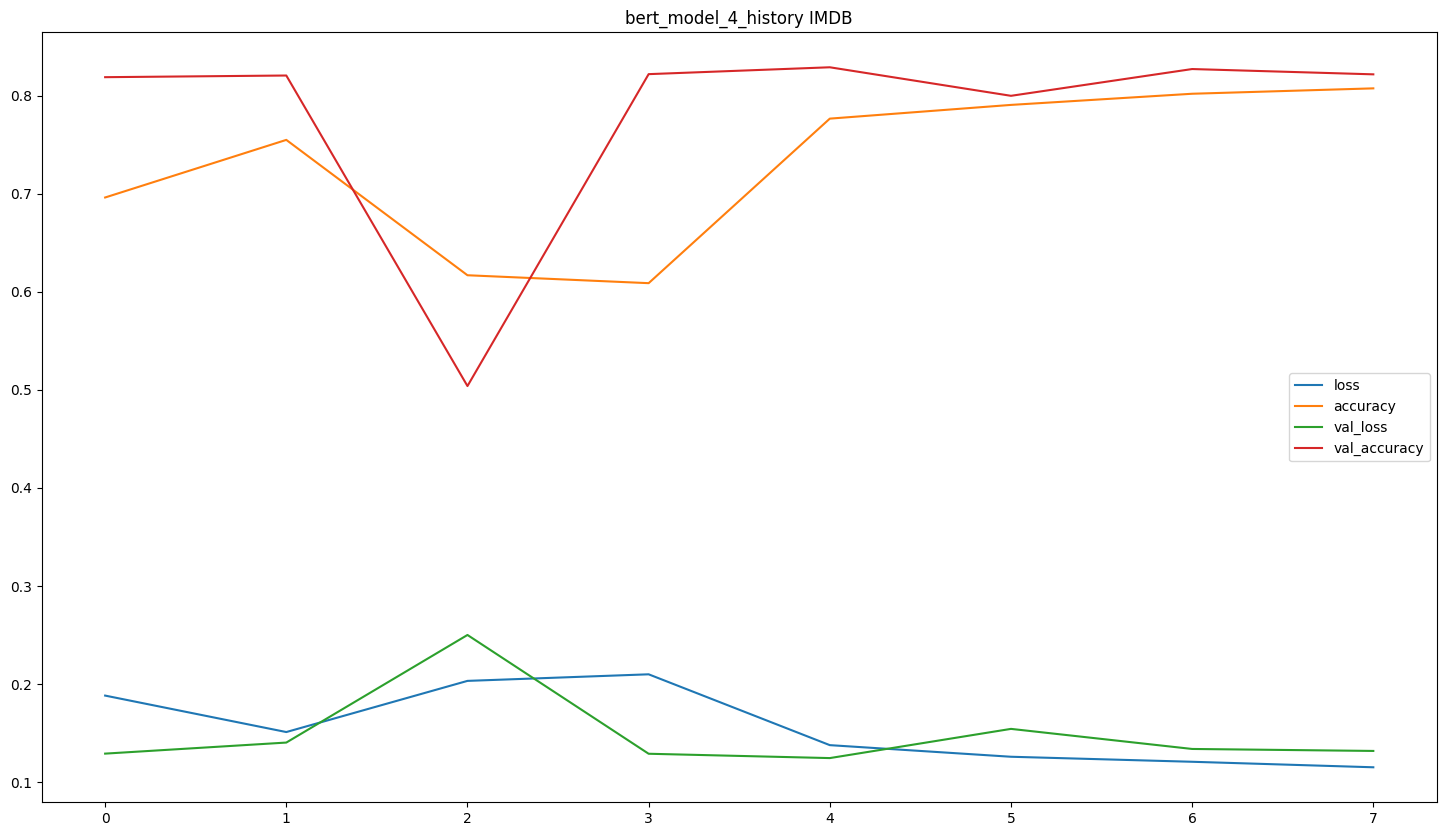

In [4]:
from tensorflow.keras.callbacks import EarlyStopping

# Create an EarlyStopping instance
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3,         
    verbose=1,       
    restore_best_weights=True
)


# Train the model 
new_bert_model_4_history = new_bert_model_4.fit(train_dataset.shuffle(1000).batch(16),
                                       epochs=50,
                                       validation_data=val_dataset.shuffle(1000).batch(16), 
                                      callbacks=[early_stopping])

# Plot history (aka loss curve or a training curve)
pd.DataFrame(new_bert_model_4_history.history).plot(figsize=(18,10), title = "bert_model_4_history IMDB")

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

batch_size = 32
predictions = []

# Iterate through validation data in batches
for i in range(0, len(x_val), batch_size):
    batch_tokenized = tokenizer(list(x_val[i: i + batch_size]), padding='max_length', truncation=True, max_length=max_length, return_tensors='tf')
    
    # Only select the input_ids and attention_mask from the tokenized data
    batch_inputs = {'input_ids': batch_tokenized['input_ids'], 'attention_mask': batch_tokenized['attention_mask']}
    
    # Move to CPU 
    with tf.device('/CPU:0'):
        batch_predictions = new_bert_model_4(batch_inputs)
    
        # Get the predicted class 
        # Threshold these probabilities at 0.5
        batch_predictions = (batch_predictions > 0.5).numpy().astype(int).flatten()

        predictions.extend(batch_predictions)

# Convert predictions to a numpy array
predictions = np.array(predictions)

# Evaluate metrics
accuracy = accuracy_score(y_val[:len(predictions)], predictions)
precision = precision_score(y_val[:len(predictions)], predictions)
recall = recall_score(y_val[:len(predictions)], predictions)
f1 = f1_score(y_val[:len(predictions)], predictions)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("f1:", f1)

Accuracy: 0.829
Precision: 0.8050210738501008
Recall: 0.8717999603095853
f1: 0.8370807926829269
